This script is meant to be used for preparing the data required to train a diagnostics model. The original Cambridge sound database contains 200G sound data, we use only the English voice data. The following steps summarize the preparation work.

1. Merge the separate metadata .csv files into one
2. Filter the merged metadata file and keep only the wavs that are needed (filter by symptom, language, etc.)
3. Loop through samples and save audio files in a new folder (rather than in hierarchical folders)
4. Save a new metadata file that describes the info of these filtered audio samples

In [66]:
import pandas as pd
import numpy as np
import os
import shutil
import glob
from path import Path

In [67]:
OG_PATH = '/mnt/d/projects/COVID-datasets/Cambridge/covid19_data_0426'
WAV_FOLDER = OG_PATH + '/covid19_data_0426'
METADATA_FOLDER = OG_PATH + '/all_metadata'

In [68]:
# Merge
df_android = pd.read_csv(os.path.join(METADATA_FOLDER, 'results_raw_20210426_lan_yamnet_android_noloc.csv'), sep=';')
df_ios = pd.read_csv(os.path.join(METADATA_FOLDER, 'results_raw_20210426_lan_yamnet_ios_noloc.csv'), sep=';')
df = pd.concat((df_ios,df_android),ignore_index=True)
df = df.iloc[:,1:]
df.shape

(48045, 18)

In [69]:
# Get only EN samples
df_new = df[df['Language']=='en'].copy()

# Generate symptom label (symptomatic vs non-symptomatic)
df_new['Symptom-label'] = 'symptomatic'
mask1 = df_new.Symptoms.str.contains('None',case=False)
df_new.loc[mask1,'Symptom-label'] = 'non'
mask2 = df_new.Symptoms.str.contains('pnts',case=False)
df_new.loc[mask2,'Symptom-label'] = 'na'
df_new = df_new[df_new['Symptom-label'] != 'na']

# Get those that have the 'valid' checkmark
df_new = df_new[df_new['Voice check'] == 'v']
# df_new = df_new[df_new['Sampling Rate'] >= 16000]

# The wav files are already in .wav format but this is not updated in the original metadata file, hence we update it here
df_new['Voice filename'] = df_new['Voice filename'].str.replace(r'.m4a$', '.wav')

# Add full path to the audios as we will need it later
df_new['voice-path'] = WAV_FOLDER + '/' + df_new['Uid']+'/'+df_new['Folder Name']+'/'+df_new['Voice filename']

# Clean up index
df_new = df_new.reset_index(drop=True)

# Summary
df_new['Symptom-label'].value_counts()

/tmp/ipykernel_23214/3877065774.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_new['Voice filename'] = df_new['Voice filename'].str.replace(r'.m4a$', '.wav')


symptomatic    12432
non             9883
Name: Symptom-label, dtype: int64

In [70]:
WAV_FOLDER_EN = os.path.join(WAV_FOLDER, 'EN') 

In [7]:
# create a new folder to store the EN wav files
os.mkdir(WAV_FOLDER_EN)

# start copying...
# wav files in the new folder are named as "00001.wav", "00002.wav", ...
for idx , row in df_new.iterrows():
    src = row['voice-path']
    dst = os.path.join(WAV_FOLDER_EN, f'{idx:05}.wav')
    shutil.copyfile(src, dst)

In [35]:
# create a new column in dataframe to store the new paths, we will use these paths to access wav files during training.
new_path = []
for idx , row in df_new.iterrows():
    new_path.append(os.path.join('./data_og/Cambridge/wav/EN', f'{idx:05}.wav'))

df_new['voice-path-new'] = new_path

In [14]:
df_new['voice-path-new']

0        ./data_og/Cambridge/wav/EN/00000.wav
1        ./data_og/Cambridge/wav/EN/00001.wav
2        ./data_og/Cambridge/wav/EN/00002.wav
3        ./data_og/Cambridge/wav/EN/00003.wav
4        ./data_og/Cambridge/wav/EN/00004.wav
                         ...                 
21621    ./data_og/Cambridge/wav/EN/21621.wav
21622    ./data_og/Cambridge/wav/EN/21622.wav
21623    ./data_og/Cambridge/wav/EN/21623.wav
21624    ./data_og/Cambridge/wav/EN/21624.wav
21625    ./data_og/Cambridge/wav/EN/21625.wav
Name: voice-path-new, Length: 21626, dtype: object

In [36]:
local_data_path = '/home/yizhu/projects/transfer-learning-diagnostics/data_og/Cambridge/metadata/'
df_new.to_csv(os.path.join(local_data_path,'EN-metadata.csv'),index=False,header=True,sep=';')

Now simply do ```! zip -r EN.zip en/*.wav``` to create a zip file of the EN folder, then move it to ```./data_og/Cambridge/wav``` folder. Our pipeline will automatically unzip the file and prepare it for subsequent training.

In [15]:
df_new

,Uid,Age,Sex,Medhistory,Smoking,Language,Date,Folder Name,Symptoms,Covid-Tested,...,Voice filename,Cough filename,Breath filename,Voice check,Cough check,Breath check,Sampling Rate,Symptom-label,voice-path,voice-path-new
0,00ELrVjrzo6L,20-29,Male,None,never,en,16-11-2020 06:07:54,2020-11-16-06_08_08_314177,None,neverThinkHadCOVIDNow,...,audio_file_read.wav,audio_file_cough.m4a,audio_file_breathe.m4a,v,c,b,44100,non,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/00000.wav
1,00nJAQ2uNrUW,20-29,Male,None,21+,en,02-11-2020 17:38:28,2020-11-02-17_38_31_912629,None,negativeLast14,...,audio_file_read.wav,audio_file_cough.m4a,audio_file_breathe.m4a,v,c,n,44100,non,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/00001.wav
2,00PM5iIqU9ML,60-69,Male,None,ex,en,03-11-2020 08:03:59,2020-11-03-08_04_00_950386,None,neverThinkHadCOVIDNever,...,audio_file_read.wav,audio_file_cough.m4a,audio_file_breathe.m4a,v,c,b,44100,non,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/00002.wav
3,00PM5iIqU9ML,60-69,Male,None,ex,en,05-11-2020 08:05:15,2020-11-05-08_05_16_256045,None,neverThinkHadCOVIDNever,...,audio_file_read.wav,audio_file_cough.m4a,audio_file_breathe.m4a,v,c,b,44100,non,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/00003.wav
4,00PM5iIqU9ML,60-69,Male,None,ex,en,07-11-2020 08:06:39,2020-11-07-08_06_40_382701,None,neverThinkHadCOVIDNever,...,audio_file_read.wav,audio_file_cough.m4a,audio_file_breathe.m4a,v,c,b,44100,non,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/00004.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21621,ZzUx4LbHGP,40-49,Male,asthma,ex,en,21-10-2020 08:01:57,2020-10-21-09_00_07_724553,tightness,neverThinkHadCOVIDNever,...,voice_ZzUx4LbHGP_1603263717657.wav,cough_ZzUx4LbHGP_1603263717646.wav,breaths_ZzUx4LbHGP_1603263717595.wav,v,n,b,16000,symptomatic,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/21621.wav
21622,ZzUx4LbHGP,40-49,Male,asthma,ex,en,22-09-2020 07:11:37,2020-09-22-06_11_39_042452,None,neverThinkHadCOVIDNever,...,voice_ZzUx4LbHGP_1600755097543.wav,cough_ZzUx4LbHGP_1600755097536.wav,breaths_ZzUx4LbHGP_1600755097472.wav,v,c,b,16000,non,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/21622.wav
21623,ZzUx4LbHGP,40-49,Male,asthma,ex,en,08-10-2020 19:09:33,2020-10-08-18_09_35_334998,tightness,neverThinkHadCOVIDNever,...,voice_ZzUx4LbHGP_1602180573914.wav,cough_ZzUx4LbHGP_1602180573904.wav,breaths_ZzUx4LbHGP_1602180573850.wav,v,c,b,16000,symptomatic,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/21623.wav
21624,ZzUx4LbHGP,40-49,Male,asthma,ex,en,04-10-2020 09:25:12,2020-10-04-08_25_14_118756,None,neverThinkHadCOVIDNever,...,voice_ZzUx4LbHGP_1601799912611.wav,cough_ZzUx4LbHGP_1601799912604.wav,breaths_ZzUx4LbHGP_1601799912542.wav,v,c,b,16000,non,/mnt/d/projects/COVID-datasets/Cambridge/covid...,./data_og/Cambridge/wav/EN/21624.wav


In [51]:
mask = (df_new['Sampling Rate'] == 8000)
toy = df_new[mask]['voice-path']

In [52]:
toy

12334    /mnt/d/projects/COVID-datasets/Cambridge/covid...
12364    /mnt/d/projects/COVID-datasets/Cambridge/covid...
12365    /mnt/d/projects/COVID-datasets/Cambridge/covid...
12486    /mnt/d/projects/COVID-datasets/Cambridge/covid...
12487    /mnt/d/projects/COVID-datasets/Cambridge/covid...
                               ...                        
22187    /mnt/d/projects/COVID-datasets/Cambridge/covid...
22188    /mnt/d/projects/COVID-datasets/Cambridge/covid...
22215    /mnt/d/projects/COVID-datasets/Cambridge/covid...
22244    /mnt/d/projects/COVID-datasets/Cambridge/covid...
22305    /mnt/d/projects/COVID-datasets/Cambridge/covid...
Name: voice-path, Length: 594, dtype: object

In [56]:
import torchaudio
signal,sr = torchaudio.load(toy.iloc[1])

In [58]:
import torch
signal = torch.mean(signal, axis=0)

/home/yizhu/anaconda3/envs/myenv-ANO/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


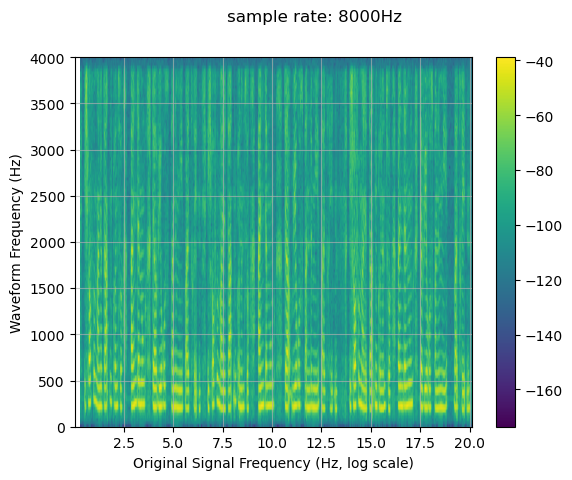

In [60]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 1)
_, _, _, cax = axis.specgram(signal.numpy(), Fs=sr)
axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
axis.set_ylabel("Waveform Frequency (Hz)")
axis.xaxis.grid(True, alpha=0.67)
axis.yaxis.grid(True, alpha=0.67)
figure.suptitle("sample rate: 8000Hz")
plt.colorbar(cax)
plt.show(block=True)

In [63]:
import torchaudio.functional as F
signal_resampled = F.resample(signal,sr,new_freq=16000)
signal_resampled  = signal_resampled.squeeze()

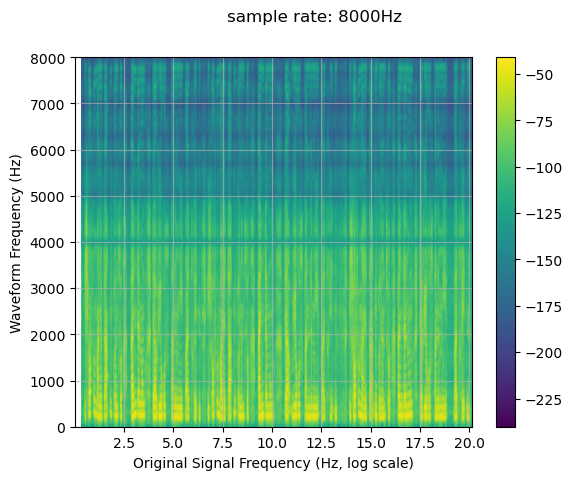

In [65]:
figure, axis = plt.subplots(1, 1)
_, _, _, cax = axis.specgram(signal_resampled.numpy(), Fs=16000)
axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
axis.set_ylabel("Waveform Frequency (Hz)")
axis.xaxis.grid(True, alpha=0.67)
axis.yaxis.grid(True, alpha=0.67)
figure.suptitle("sample rate: 8000Hz")
plt.colorbar(cax)
plt.show(block=True)